In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_niblack, threshold_sauvola
import kagglehub
from scipy.ndimage import distance_transform_edt

In [6]:
path = kagglehub.dataset_download(
    "andrewmvd/drive-digital-retinal-images-for-vessel-extraction"
)

image_dir = f"{path}/DRIVE/training/images"
gt_dir    = f"{path}/DRIVE/training/1st_manual"
fov_dir   = f"{path}/DRIVE/training/mask"

images = sorted(os.listdir(image_dir))
gts  = sorted(os.listdir(gt_dir))
fovs = sorted(os.listdir(fov_dir))

Using Colab cache for faster access to the 'drive-digital-retinal-images-for-vessel-extraction' dataset.


In [7]:
def dice(pred, gt):
    tp = np.sum((pred == 1) & (gt == 1))
    fp = np.sum((pred == 1) & (gt == 0))
    fn = np.sum((pred == 0) & (gt == 1))
    return (2 * tp) / (2 * tp + fp + fn + 1e-8)

def sensitivity(pred, gt):
    tp = np.sum((pred == 1) & (gt == 1))
    fn = np.sum((pred == 0) & (gt == 1))
    return tp / (tp + fn + 1e-8)

In [8]:
def extract_thin_regions(gt):
    distance_map = distance_transform_edt(gt)
    thin_region = ((gt == 1) & (distance_map <= 2)).astype(np.uint8)
    return thin_region

In [9]:
def preprocessing(img):
    green_channel = img[:, :, 1]
    clahe = cv2.createCLAHE(2.0, (8,8))
    return clahe.apply(green_channel)

In [10]:
window_size = [15, 25, 35, 45]
niblack_k_vals = [-0.3, -0.2, -0.1, 0.1]
sauvola_k_vals = [0.1, 0.2, 0.3, 0.4]
R = 60

In [11]:
def get_thin_vessels(gt):
    dist = distance_transform_edt(gt)
    thin = ((gt == 1) & (dist <= 2)).astype(np.uint8)

    return thin

In [12]:
best_niblack_score = 0
best_niblack_params = None
print("Niblack: ")

for w in window_size:
    for k in niblack_k_vals:
        thin_list = []
        dice_list = []

        for idx in range(len(images)):
            img = cv2.imread(os.path.join(image_dir, images[idx]))
            gt  = cv2.imread(os.path.join(gt_dir, gts[idx]), 0)
            fov = cv2.imread(os.path.join(fov_dir, fovs[idx]), 0)

            img = preprocessing(img)
            gt  = (gt > 0).astype(np.uint8)
            fov = (fov > 0).astype(np.uint8)
            gt = gt * fov

            thresh = threshold_niblack(img, window_size=w, k=k)
            prediction = (img < thresh).astype(np.uint8) * fov

            thin_gt = get_thin_vessels(gt)

            thin_list.append(sensitivity(prediction, thin_gt))
            dice_list.append(dice(prediction, gt))

        avg_thin = np.mean(thin_list)
        avg_dice = np.mean(dice_list)

        print(f"window={w}, k={k}, ThinSens={avg_thin:.3f}")

        if avg_thin > best_niblack_score:
            best_niblack_score = avg_thin
            best_niblack_params = (w, k, avg_dice)

print("\nBest Niblack:", best_niblack_params, "Score:", best_niblack_score)

Niblack: 
window=15, k=-0.3, ThinSens=0.899
window=15, k=-0.2, ThinSens=0.877
window=15, k=-0.1, ThinSens=0.852
window=15, k=0.1, ThinSens=0.797
window=25, k=-0.3, ThinSens=0.909
window=25, k=-0.2, ThinSens=0.888
window=25, k=-0.1, ThinSens=0.864
window=25, k=0.1, ThinSens=0.810
window=35, k=-0.3, ThinSens=0.905
window=35, k=-0.2, ThinSens=0.883
window=35, k=-0.1, ThinSens=0.857
window=35, k=0.1, ThinSens=0.803
window=45, k=-0.3, ThinSens=0.897
window=45, k=-0.2, ThinSens=0.872
window=45, k=-0.1, ThinSens=0.846
window=45, k=0.1, ThinSens=0.789

Best Niblack: (25, -0.3, np.float64(0.33234148458409973)) Score: 0.9091694230966537


In [13]:
best_sauvola_score = 0
best_sauvola_params = None
print("Sauvola: ")

for w in window_size:
    for k in sauvola_k_vals:
        thin_list = []
        dice_list = []

        for idx in range(len(images)):
            img = cv2.imread(os.path.join(image_dir, images[idx]))
            gt  = cv2.imread(os.path.join(gt_dir, gts[idx]), 0)
            fov = cv2.imread(os.path.join(fov_dir, fovs[idx]), 0)

            img = preprocessing(img)
            gt  = (gt > 0).astype(np.uint8)
            fov = (fov > 0).astype(np.uint8)
            gt = gt * fov

            thresh = threshold_sauvola(img, window_size=w, k=k, r=R)
            prediction = (img < thresh).astype(np.uint8) * fov

            thin_gt = get_thin_vessels(gt)

            thin_list.append(sensitivity(prediction, thin_gt))
            dice_list.append(dice(prediction, gt))

        avg_thin = np.mean(thin_list)
        avg_dice = np.mean(dice_list)

        print(f"window={w}, k={k}, ThinSens={avg_thin:.3f}")

        if avg_thin > best_sauvola_score:
            best_sauvola_score = avg_thin
            best_sauvola_params = (w, k, avg_dice)

print("\nBest Sauvola:", best_sauvola_params, "Score:", best_sauvola_score)

Sauvola: 
window=15, k=0.1, ThinSens=0.661
window=15, k=0.2, ThinSens=0.473
window=15, k=0.3, ThinSens=0.318
window=15, k=0.4, ThinSens=0.210
window=25, k=0.1, ThinSens=0.698
window=25, k=0.2, ThinSens=0.527
window=25, k=0.3, ThinSens=0.373
window=25, k=0.4, ThinSens=0.256
window=35, k=0.1, ThinSens=0.705
window=35, k=0.2, ThinSens=0.548
window=35, k=0.3, ThinSens=0.400
window=35, k=0.4, ThinSens=0.280
window=45, k=0.1, ThinSens=0.701
window=45, k=0.2, ThinSens=0.557
window=45, k=0.3, ThinSens=0.415
window=45, k=0.4, ThinSens=0.296

Best Sauvola: (35, 0.1, np.float64(0.5893384040874301)) Score: 0.7045418614225147


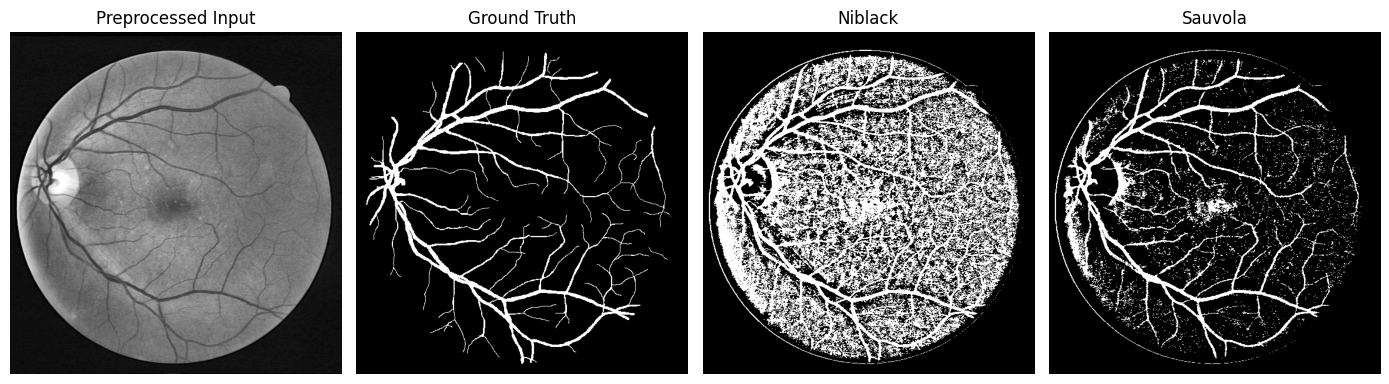

In [15]:
best_w_n, best_k_n, _ = best_niblack_params
best_w_s, best_k_s, _ = best_sauvola_params

sample_idx = 0

image = cv2.imread(os.path.join(image_dir, images[sample_idx]))
ground_truth = cv2.imread(os.path.join(gt_dir, gts[sample_idx]), 0)
mask = cv2.imread(os.path.join(fov_dir, fovs[sample_idx]), 0)


processed_img = preprocessing(image)

ground_truth = (ground_truth > 0).astype(np.uint8)
mask = (mask > 0).astype(np.uint8)

niblack_map = threshold_niblack(processed_img, window_size=best_w_n, k=best_k_n)
sauvola_map = threshold_sauvola(processed_img, window_size=best_w_s, k=best_k_s, r=R)

niblack_result = (processed_img < niblack_map).astype(np.uint8) * mask
sauvola_result = (processed_img < sauvola_map).astype(np.uint8) * mask

plt.figure(figsize=(14, 4))

plt.subplot(1, 4, 1)
plt.imshow(processed_img, cmap='gray')
plt.title("Preprocessed Input")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(ground_truth, cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(niblack_result, cmap='gray')
plt.title("Niblack")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(sauvola_result, cmap='gray')
plt.title("Sauvola")
plt.axis('off')

plt.tight_layout()
plt.show()

Niblack detects more thin vessels but is noisy, while Sauvola gives cleaner results but misses fine vessels